In [1]:
import rputils as rp

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy import integrate, optimize
import time

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh
from pygimli.physics import TravelTimeManager

# Compare RPM with Apollo traveltimes

In [2]:
"""
Load additional data
"""

## NOTE: since this data is taken from publications, it will not be included in this repo
vel_data_path = '../data/Martella_Apollo_14.txt'
ap14_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')
vel_data_path = '../data/Martella_Apollo_16.txt'
ap16_vels = np.genfromtxt(vel_data_path, dtype=np.float32, skip_header=1, encoding='utf-8')

08/01/24 - 21:27:20 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


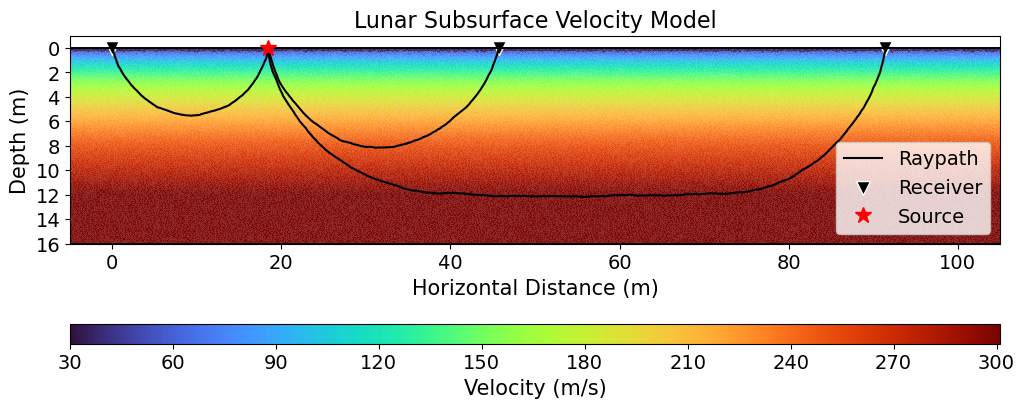

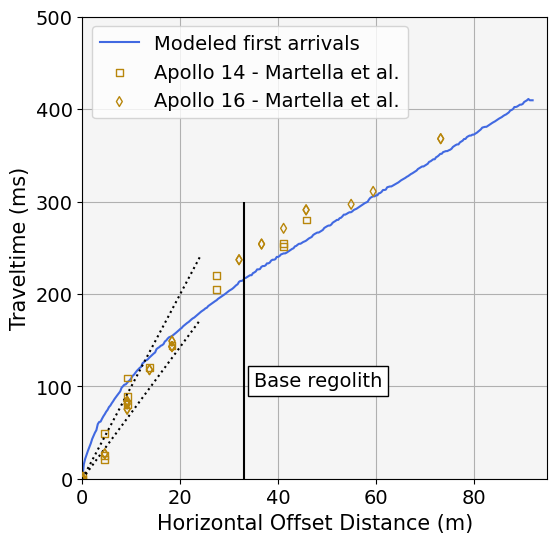

In [4]:
##~~~~~~~~~~~~~~~~~
## Velocity functions

def first_layer_vel(depth):
    """
    Equation that defines the shallow (<10m) regolith
    velocity profile
    """
    vel = 55 * (depth/0.01)**(1/6.)
    return vel

def amos_vp(depth):
    # multiplier = 1.5
    # divider = 0.000022
    # power = 0.42

    multiplier = 35
    divider = 0.1
    power = 0.45
    
    vel = multiplier * (depth/divider)**power
    return vel

def fit_vel(depth):
    multiplier = 1
    divider = 0.00000075
    power = 1/3
    vel = multiplier * (depth/divider)**power
    return vel

def apollo_fit_vel(depth):
    """
    Use the BA model +PR fit, adjust RP model parameters
    (i.e. contact ratio) to try to make a velocity
    profile that is consistent with Apollo observations
    """
    multiplier = 1.5
    divider = 0.000004
    power = 0.35
    vel = multiplier * (depth/divider)**power
    return vel

def gangi_vel(depth):
    """
    From gangi and Yen 1979
    """
    vel = 220*depth**(1/6)
    return vel


second_layer_depth = 12.
second_layer_velocity = 300.


plc = mt.createWorld([-10, -16], [110, 0], worldMarker=False)

sensors = np.linspace(0, 91.4, 21)
for pos in sensors:
    plc.createNode([pos, 0.0])
    
mesh_gradient = mt.createMesh(plc, quality=33, area=0.07, smooth=[2,20])  ##hires
# mesh_gradient = mt.createMesh(plc, quality=33, area=0.3, smooth=[2,20])


vel_gradient = []
for node in mesh_gradient.nodes():
    
    if node.y() < -1*second_layer_depth:
        vel_gradient.append(second_layer_velocity)
    else:
        # vel_gradient.append(first_layer_vel(abs(node.y())))
        # vel_gradient.append(gangi_vel(abs(node.y())))
        # vel_gradient.append(amos_vp(abs(node.y()))*.75)  #reduce for anisotropy
        vel_gradient.append(amos_vp(abs(node.y())))
    
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient,
                                               np.array(vel_gradient))



##~~~~~~~~~~~~~~~~~
## Raytrace Plot

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# for boundary in mesh_gradient.boundaries():
#     boundary.setMarker(0)

mesh_gradient.createNeighborInfos()

# In order to use the Dijkstra, we extract the surface positions >0
mx = pg.x(mesh_gradient)
my = pg.y(mesh_gradient)
px = np.sort(mx[my == 0.0])

# A data container with index arrays named s (shot) and g (geophones) is
# created and filled with the positions and shot/geophone indices.
data = pg.DataContainer()
data.registerSensorIndex('s')
data.registerSensorIndex('g')

nData = 0
comp_offsets = []
for i, pxi in enumerate(px):
    if not 0<=pxi<92:
        continue
    data.createSensor([pxi, 0.0])
    nData += 1
    comp_offsets.append(pxi)
    # if pxi == 0.0:
    #     source = i
comp_offsets = np.array(comp_offsets)
source = 0

# nData = len(px)
data.resize(nData)
data['s'] = [source] * nData # only one shot at first sensor
data['g'] = range(nData)  # and all sensors are receiver geophones

# Draw initial mesh with velocity distribution
vel_plot, cb = pg.show(mesh_gradient, vel_gradient, ax=ax, hold=True,
        logScale=False, cMap="turbo", coverage=None, fitView=False, pad=0.8)
cb.ax.tick_params(labelsize=14)
cb.set_label(label="Velocity (m/s)", size=15)
# drawMesh(ax, mesh_gradient, color="white", lw=0.21)


sec_nodes = 5
mgr = TravelTimeManager()
recs = [0, 45.7, 91.4]
plot_source_x = 18.4
# plot_source_x = 12.6

res = mgr.simulate(vel=vel_gradient, scheme=data, mesh=mesh_gradient, secNodes=sec_nodes)
t_all = res['t'].array()

for r, p in enumerate(recs):
    if r == 0:
        lab = "Raypath"
    else:
        lab = None
    recNode = mgr.fop.mesh().findNearestNode([sensors[(np.abs(sensors-p)).argmin()], 0.0])
    # sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])
    sourceNode = mgr.fop.mesh().findNearestNode([plot_source_x, 0.0])

    path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
    points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
    ax.plot(points[:,0], points[:,1], "black", label=lab)


# Draw sensor positions for the selected receivers
# for p in recs:
#     ax.plot(sensors[(np.abs(sensors-p)).argmin()], 0.0, "kv", ms=10)
# ax.plot(sensors[(np.abs(sensors-p)).argmin()], 0.0, "kv", ms=10, label='Receiver')  # double plotting last one for the label
for p in recs:
    ax.scatter(sensors[(np.abs(sensors-p)).argmin()], 0., marker="v", s=100, facecolors="black", edgecolors="white")
ax.scatter(sensors[(np.abs(sensors-p)).argmin()], 0.0, marker="v", s=100, label='Receiver',
           facecolors="black", edgecolors="white")  # double plotting last one for the label
ax.plot(plot_source_x, 0.0, "r*", ms=12, label='Source')
ax.set_ylim(mesh_gradient.ymin(), 2)

## Control the colorbar in the plot
min_c = 30
max_c = 301
tick_increment = 30
ticks = np.arange(min_c, max_c, tick_increment)
cb.mappable.set_clim(min_c, max_c)
cb.ax.xaxis.set_ticks(ticks)
# cb.solids.set_edgecolor("face")  # gets rid of weird lines

ax.set_title("Lunar Subsurface Velocity Model", fontsize=16)
ax.set_xlabel("Horizontal Distance (m)", fontsize=15)
ax.legend(loc="lower right", fontsize=14)
ticks =  ax.get_yticks()
ax.set_yticks(ticks=ticks,
              labels=np.abs(ticks).astype("int"))
ax.tick_params(labelsize=14)
ax.set_xlim(-5, 105)
ax.set_ylim(-16, 1)
ax.set_ylabel("Depth (m)", fontsize=15)

# plt.tight_layout()
# plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig10_velocity_section.jpg", dpi=1000, bbox_inches = "tight")
plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig10_velocity_section.pdf", dpi=600, bbox_inches="tight")



##~~~~~~~~~~~~~~~~~
## Traveltime Plot

## Average vel lines
avg_vel1 = 100
avg_vel2 = 140
avg_vel3 = 200
avg_val_compdist = 25  #offset distance over which to plot layer 1 avg vel
avg_plot_dist = np.arange(avg_val_compdist)
avg_times1 = avg_plot_dist/(avg_vel1/1000)
avg_times2 = avg_plot_dist/(avg_vel2/1000)
avg_times3 = avg_plot_dist/(avg_vel3/1000)


fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=False)
t_all = medfilt(t_all, kernel_size=7)
dot_size=25
ax.plot(comp_offsets, t_all * 1000, zorder=1, color="royalblue", label="Modeled first arrivals")
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='s', edgecolors='darkgoldenrod', s=dot_size, 
           facecolors='None', label='Apollo 14 - Martella et al.', zorder=2)
ax.scatter(ap16_vels[:,0],ap16_vels[:,1], marker='d', edgecolors='darkgoldenrod', s=dot_size, 
           facecolors='None', label='Apollo 16 - Martella et al.', zorder=3)

gidxs = []
for p in recs:
    curr_gidx = (np.abs(comp_offsets-p)).argmin()
    gidxs.append(curr_gidx)
# ax.scatter(comp_offsets[gidxs], t_all[gidxs] * 1000, marker='v', c='black', s=50,
#           label='Modeled Receiver', zorder=3)
ax.set(axisbelow=True,
      facecolor="whitesmoke")
ax.set_xlabel("Horizontal Offset Distance (m)", fontsize=15)
ax.set_ylabel("Traveltime (ms)", fontsize=15)

ax.plot(avg_plot_dist, avg_times1, ls=":", color="black")
ax.plot(avg_plot_dist, avg_times2, ls=":", color="black")
# ax.plot(avg_plot_dist, avg_times3, ls="--", color="black")

ax.vlines(33, ymin=0, ymax=300, color="black")
ax.text(35, 100, "Base regolith", 
        bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"},
       horizontalalignment='left', fontsize=14)
ax.tick_params(labelsize=14)
ax.grid("both")
ax.legend(fontsize=14)
plt.xlim(0,95)
plt.ylim(0,500)

# plt.show()
# plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/fig11_first_arrivals.jpg", dpi=1000, bbox_inches = "tight")
plt.savefig("../../../Research Work/Papers/pub1/pub1_figs/PDF/fig11_first_arrivals.pdf", dpi=600, bbox_inches="tight")

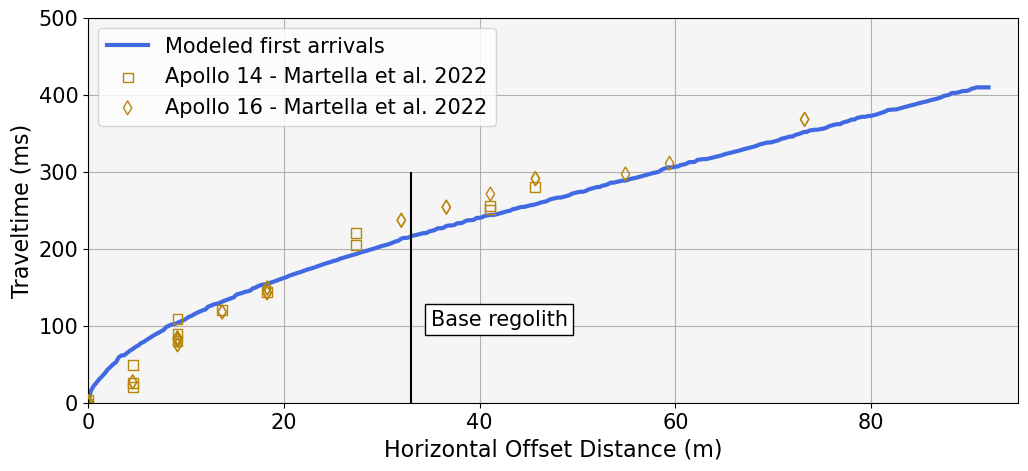

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=False)
t_all = medfilt(t_all, kernel_size=7)
dot_size=50
ax.plot(comp_offsets, t_all * 1000, zorder=1, color="royalblue", label="Modeled first arrivals", lw=3)
ax.scatter(ap14_vels[:,0],ap14_vels[:,1], marker='s', edgecolors='darkgoldenrod', s=dot_size, 
           facecolors='None', label='Apollo 14 - Martella et al. 2022', zorder=2)
ax.scatter(ap16_vels[:,0],ap16_vels[:,1], marker='d', edgecolors='darkgoldenrod', s=dot_size, 
           facecolors='None', label='Apollo 16 - Martella et al. 2022', zorder=3)

gidxs = []
for p in recs:
    curr_gidx = (np.abs(comp_offsets-p)).argmin()
    gidxs.append(curr_gidx)
ax.set(axisbelow=True,
      facecolor="whitesmoke")
ax.set_xlabel("Horizontal Offset Distance (m)", fontsize=16)
ax.set_ylabel("Traveltime (ms)", fontsize=16)

ax.vlines(33, ymin=0, ymax=300, color="black")
ax.text(35, 100, "Base regolith", 
        bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"},
       horizontalalignment='left', fontsize=15)
ax.tick_params(labelsize=15)
ax.grid("both")
ax.legend(fontsize=15)
plt.xlim(0,95)
plt.ylim(0,500)

plt.show()

# Model icy lunar regolith

In [4]:
"""
Functions and Constants
"""

## RP PARAMETERS
effective_mineral_k = 80.95
effective_mineral_u = 43.46
eff_min_density = 2.98
ice_k = 8.95
ice_u = 3.59
ice_dens = 0.92
C = 3
critical_porosity = 0.6  # 0.664 average from helium pyc, even higher on low-accuracy liquid pyc
fitting_por = 0.42  # fit porosity for max_poissons
max_poisson_list = [0.44, 0.426, 0.415, 0.409]  # Based on the observed average velocities
contact_ratios = [0.5, 0.9, 0.9, 0.9]  # for Bachrach HM
slip_percent = 0.5  # for Bachrach HM
pressures = [0.000005, 0.00003, 0.000055, 0.00008] # in GPa
max_cement = 0.1


## MODELING HELPER FUNCTIONS
## Perform polynomial fit to average PR values from measurements
_fitpres = np.insert(pressures, 0, 0.0000001)
_fitpr = np.insert(max_poisson_list, 0, 0.49) 
pr_pres_fit = np.poly1d(np.polyfit(_fitpres**(1/10), _fitpr, deg=3))

## Porosity increase due to granular ice
_ice_percs = [0.02, 0.05, 0.1, 0.2]
_ice_percs_vol = [(i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)) for i in _ice_percs]
_por_inc = [0, 0.03]
_ice_perc = [0, _ice_percs_vol[-1]]
ice_por_inc_fit = np.poly1d(np.polyfit(_ice_perc, _por_inc, deg=1))


## Use a function to adjust PR based on ice content
def pr_ice_fit(pr, ice, f=0.97):
    x_scaling = np.arange(0,1., 0.002)
    y_scaling = x_scaling**(1/4)
    y_scaling = [(i-np.amin(y_scaling))/(np.amax(y_scaling)-np.amin(y_scaling)) for i in y_scaling]
    scale_val = y_scaling[np.abs(x_scaling-ice).argmin()]
    low_val = scale_val * (pr * f)
    upper_val = (1-scale_val) * pr
    scaled_pr = low_val + upper_val

    return scaled_pr


eff_cemented_cem = 0.33
eff_granular_cem = [0, 0.2, 0.16, 0.14, 0.12]
def eff_cem_fit_func(ice_vol, num, exp, bias):
    fit = num/ice_vol**exp + bias
    return fit
initial_guess = [0.01, 0.5, 0.1]
eff_cem_fit_parms, _ = optimize.curve_fit(eff_cem_fit_func, _ice_percs_vol, 
                                  eff_granular_cem[1:], p0=initial_guess)



##  SUBSURFACE PROPERTIES
##  POROSITY, DENSITY, PRESSURE PROFILES
## Acceleration due to gravity, in m/s
grav_accel = 1.625

## Specific gravity of regolith
sg_high = 3.24

## Depth range, in m
max_depth = 20
depth_step = 0.01
depths = np.arange(0,max_depth,depth_step)

## Density equations from Lunar Sourcebook, in g/cm3, page 494
## Assume 5% error for lows and highs calculations
dens_err = 0.05
densities_hyp = 1.92 * ((depths*100 + 12.2)/(depths*100 + 18))   #hyperbolic function
densities_pow = 1.39*(depths*100)**0.056
dens_stk = np.vstack((densities_hyp, densities_pow))
dens_low = np.amin(dens_stk, axis=0) * (1-dens_err)

## Calculate porosity low and high
por_high = 1 - (dens_low / sg_high)

## Pressure, in MPa
integrated_density_low = integrate.cumulative_trapezoid(dens_low)
ss_pressures_low = np.cumsum((grav_accel * integrated_density_low * depth_step) / 1e6)
ss_pressures_low = np.hstack((0, ss_pressures_low))


## ICY VELOCITY MODEL FUNCTIONS
def ice_por_pres(ice_vol):
    ## Make ice profile
    ice_profile = np.full(depths.shape, ice_vol)
    por_inc = ice_por_inc_fit(ice_profile)

    ## Icy density profiles
    ## Just assume reg density of 3 and ice 0.92
    dens_diff = 0.92/3
    ice_sg_high = 3.24 - (dens_diff*ice_vol*3.24)
    ice_dens_low = dens_low - (dens_diff*ice_vol*dens_low)
    min_dens = ice_sg_high * (1 - 0.66 + por_inc[0])
    ice_dens_low = np.clip(ice_dens_low, a_min=min_dens, a_max=None)

    ## Calculate porosity
    ice_por_high = (1 - (ice_dens_low / ice_sg_high)) + por_inc
    
    ## Pressure, in MPa
    ice_integrated_density_low = integrate.cumulative_trapezoid(ice_dens_low)
    ice_ss_pressures_low = np.cumsum((grav_accel * ice_integrated_density_low * depth_step) / 1e6)
    ice_ss_pressures_low = np.hstack((0, ice_ss_pressures_low))

    return ice_por_high, ice_ss_pressures_low


def icy_vel(depth, ice_perc, ice_structure, por_profile, pres_profile, vp_or_vs):
# def icy_vel(depth, ice_perc, ice_structure, por_profile, pres_profile):
    """
    Return Vp or Vs for given depth and ice vol%
    """

    structures = ["granular", "cemented"]
    assert ice_structure.lower() in structures, "Check ice structure input"
    ## get porosity and pressure for depth
    dep_idx = np.abs(depths - depth).argmin()

    pressure = pres_profile[dep_idx]
    pressure = pressure/1000  ## Change pressure to GPa
    
    por = por_profile[dep_idx]
    if por > critical_porosity:
        por = critical_porosity


     ## Adjust PR based on pressure, then adjust based on ice content
    p_pres = pr_pres_fit(pressure**(1/10))
    if ice_perc == 0:
        pr = p_pres
    else:
        pr = pr_ice_fit(p_pres, ice_perc)

    ## Estimate a contact ratio based on pressure
    if pressure <= pressures[0]:
        tmp_p_range = np.linspace(0, pressures[0], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(0.1, contact_ratios[0], 100) #0.4 used to be 0.25
        contact_ratio = tmp_cr_range[tmp_p_idx]
    elif pressures[0] < pressure <= pressures[1]:
        tmp_p_range = np.linspace(pressures[0], pressures[1], 100)
        tmp_p_idx = (np.abs(tmp_p_range - pressure)).argmin()
        tmp_cr_range = np.linspace(contact_ratios[0], contact_ratios[1], 100)
        contact_ratio = tmp_cr_range[tmp_p_idx]
    else:
        contact_ratio = contact_ratios[-1]

    keff, ueff = rp.models.bachrach_angular(effective_mineral_k, effective_mineral_u, 
                                            critical_porosity, C, pressure, 
                                            c_ratio=contact_ratio, slip_percent=slip_percent)

    if ice_structure.lower() == "granular":

        if ice_perc == 0:
            eff_cem = 0
        else:
            eff_cem = eff_cem_fit_func(ice_perc, *eff_cem_fit_parms)
            if eff_cem > 1:
                eff_cem = 0
        mix_amount = ice_perc * eff_cem * 10
        
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="soft", mix_amount=mix_amount)
        
        vp = rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000
        vs = rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000

    if ice_structure.lower() == "cemented":

        mix_amount = ice_perc * eff_cemented_cem * 10
        if mix_amount > 1.:
            mix_amount = 1.
        
        k_patchy, u_patchy, d_patchy = rp.models.patchy_ice_model(
                             por=por, crit_por=critical_porosity, C=C, 
                             keff=keff, ueff=ueff, 
                             k_grain=effective_mineral_k, mu_grain=effective_mineral_u, dens_grain=eff_min_density,
                             k_ice=ice_k, u_ice=ice_u, dens_ice = ice_dens,
                             fit_por=fitting_por, trans_por=0.41, max_poisson=pr,
                             contact_scheme="contact", max_cement=max_cement,
                             patchy_scheme="stiff", mix_amount=mix_amount)
        
        vp = rp.elastic.p_vel(k_patchy[0], u_patchy[0], d_patchy[0])*1000
        vs = rp.elastic.s_vel(u_patchy[0], d_patchy[0])*1000

    # Set minimum values for vp and vs
    if (np.isnan(vp) or pressure==0):
        if ice_structure.lower() == "granular":
            vp = 15
        if ice_structure.lower() == "cemented":
            vp = 1000
    if (np.isnan(vs) or pressure==0):
        if ice_structure.lower() == "granular":
            vs = 4
        if ice_structure.lower() == "cemented":
            vs=750

    if vp_or_vs.lower()=="vp":
        return vp
    elif vp_or_vs.lower()=="vs":
        return vs


def create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, ice_structure, vp_or_vs):
    """
    Return mesh and velocity
    """
    
    plc = mt.createWorld([-10, -16], [30, 0], worldMarker=False)
    for pos in sensors:
        plc.createNode([pos, 0.0])
    mesh_gradient = mt.createMesh(plc, quality=33, area=0.04, smooth=[2,20])  ##hires
    # mesh_gradient = mt.createMesh(plc, quality=33, area=0.3, smooth=[2,20])
    
    
    vel_gradient = []
    for node in mesh_gradient.nodes():
        
        if node.y() < -1*second_layer_depth:
            if vp_or_vs == "vp":
                vel_gradient.append(second_layer_velocity)
            elif vp_or_vs == "vs":
                vel_gradient.append(second_layer_vs)
        else:
            vel_gradient.append(icy_vel(abs(node.y()), ice_vol_perc, ice_structure, 
                                            por_prof, pres_prof, vp_or_vs))
        
    vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient, np.array(vel_gradient))
    mesh_gradient.createNeighborInfos()

    return mesh_gradient, vel_gradient


def raytrace(mesh_gradient, vel_gradient, recs, max_offset):
    
    # In order to use the Dijkstra, we extract the surface positions >0
    mx = pg.x(mesh_gradient)
    my = pg.y(mesh_gradient)
    px = np.sort(mx[my == 0.0])

    # A data container with index arrays named s (shot) and g (geophones) is
    # created and filled with the positions and shot/geophone indices.
    data = pg.DataContainer()
    data.registerSensorIndex('s')
    data.registerSensorIndex('g')
    
    nData = 0
    comp_offsets = []
    for i, pxi in enumerate(px):
        if not 0<=pxi<=max_offset:
            continue
        data.createSensor([pxi, 0.0])
        nData += 1
        comp_offsets.append(pxi)
    comp_offsets = np.array(comp_offsets)
    source = 0

    data.resize(nData)
    data['s'] = [source] * nData # only one shot at first sensor
    data['g'] = range(nData)  # and all sensors are receiver geophones

    sec_nodes = 5
    mgr = TravelTimeManager()
    plot_source_x = 0
    
    res = mgr.simulate(vel=vel_gradient, scheme=data, mesh=mesh_gradient, secNodes=sec_nodes)
    t_all = res['t'].array()

    points_list = []
    for r, p in enumerate(recs):
        recNode = mgr.fop.mesh().findNearestNode([sensors[(np.abs(sensors-p)).argmin()], 0.0])
        sourceNode = mgr.fop.mesh().findNearestNode([plot_source_x, 0.0])
    
        path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
        points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
        points_list.append(points)

    return points_list, t_all, comp_offsets

06/01/24 - 16:53:33 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
06/01/24 - 16:55:36 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
06/01/24 - 16:58:24 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
06/01/24 - 17:01:14 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
06/01/24 - 17:04:01 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
06/01/24 - 17:06:47 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Model build took 15.35 minutes


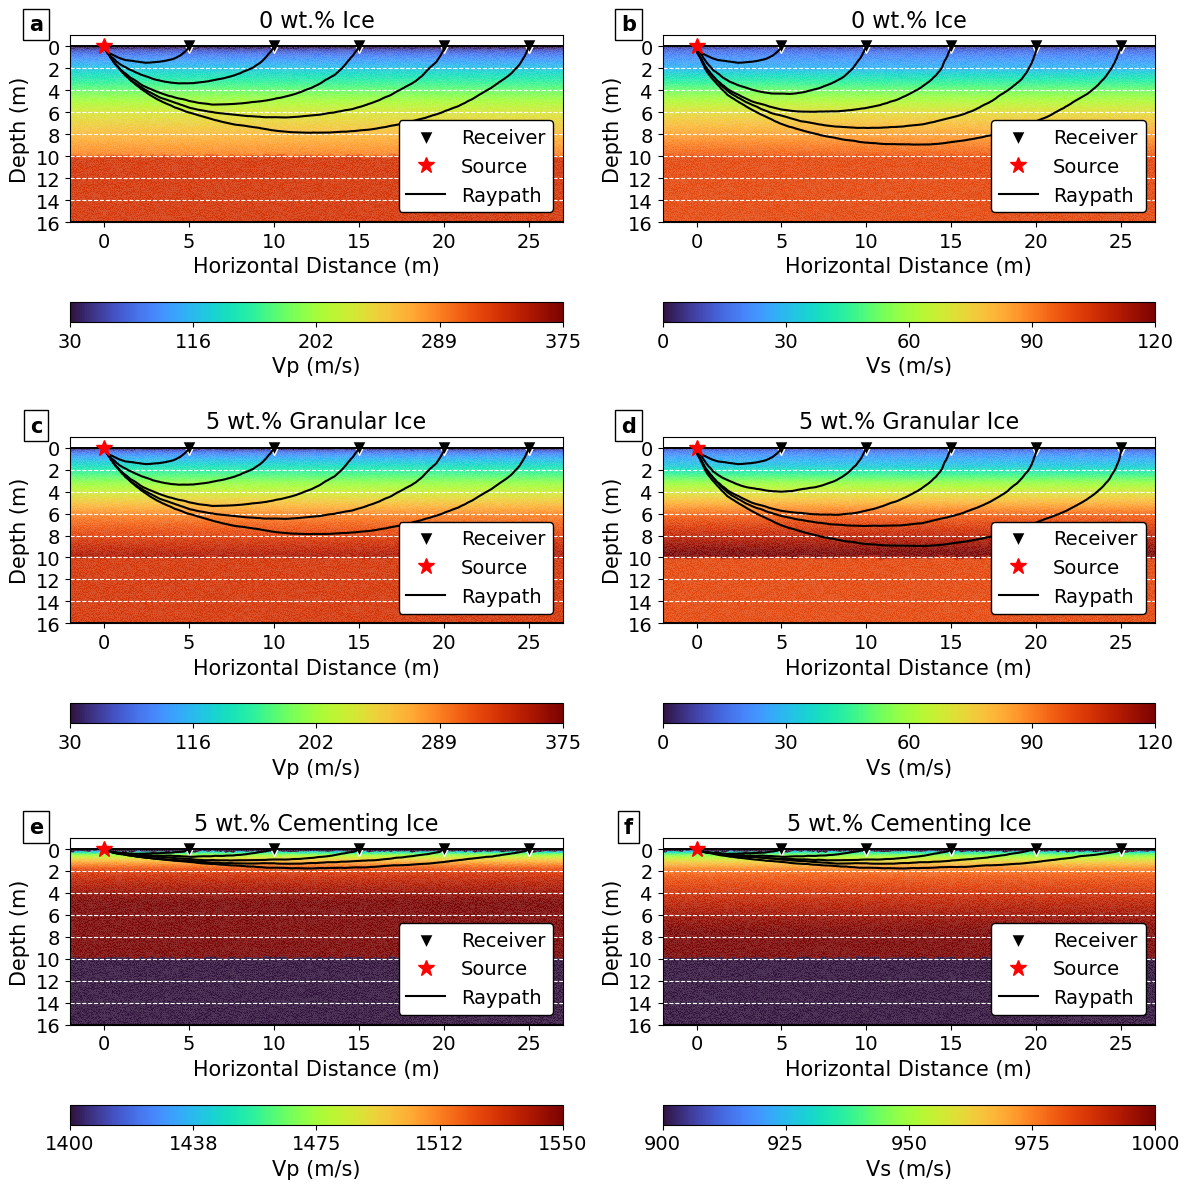

In [6]:
"""
2D icy traveltime modeling
"""

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CREATE VELOCITY MESH

ice_percs = [0.02, 0.05, 0.1, 0.2]
ice_percs_vol = [(i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)) for i in ice_percs]

second_layer_depth = 10.
second_layer_velocity = 330.
second_layer_vs = 100.


##~~~~~~~~~~~~~~~~~
## Model build and computations

start = time.time()

sensors = np.linspace(0, 25, 6)
recs = [5, 10, 15, 20, 25]

ice_vol_perc = 0
max_offset = 25
por_prof, pres_prof = ice_por_pres(ice_vol_perc)
mesh_gradient_0, vel_gradient_0 = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vp")
points_list_0, t_all_0, comp_offsets_0 = raytrace(mesh_gradient_0, vel_gradient_0,  recs, max_offset)
mesh_gradient_0_vs, vel_gradient_0_vs = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vs")
points_list_0_vs, t_all_0_vs, comp_offsets_0_vs = raytrace(mesh_gradient_0_vs, vel_gradient_0_vs,  recs, max_offset)

ice_vol_perc = ice_percs_vol[1]
por_prof, pres_prof = ice_por_pres(ice_vol_perc)
mesh_gradient_5, vel_gradient_5 = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vp")
points_list_5, t_all_5, comp_offsets_5 = raytrace(mesh_gradient_5, vel_gradient_5, recs, max_offset)
mesh_gradient_5_vs, vel_gradient_5_vs = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vs")
points_list_5_vs, t_all_5_vs, comp_offsets_5_vs = raytrace(mesh_gradient_5_vs, vel_gradient_5_vs, recs, max_offset)

ice_vol_perc = ice_percs_vol[1]
por_prof, pres_prof = ice_por_pres(ice_vol_perc)
mesh_gradient_10, vel_gradient_10 = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "cemented", "vp")
points_list_10, t_all_10, comp_offsets_10 = raytrace(mesh_gradient_10, vel_gradient_10, recs, max_offset)
mesh_gradient_10_vs, vel_gradient_10_vs = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "cemented", "vs")
points_list_10_vs, t_all_10_vs, comp_offsets_10_vs = raytrace(mesh_gradient_10_vs, vel_gradient_10_vs, recs, max_offset)

end = time.time()
print(f"Model build took {round((end-start)/60, 2)} minutes")


## PLOTS
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Draw initial mesh with velocity distribution
# cMin, cMax = 30, 430
vel_plot_0, cb_0 = pg.show(mesh_gradient_0, vel_gradient_0, ax=ax[0,0], hold=True, cMin=30, cMax=375,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
vel_plot_0_vs, cb_0_vs = pg.show(mesh_gradient_0_vs, vel_gradient_0_vs, ax=ax[0,1], hold=True, cMin=0, cMax=120,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
vel_plot_5, cb_5 = pg.show(mesh_gradient_5, vel_gradient_5, ax=ax[1,0], hold=True, cMin=30, cMax=375,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
vel_plot_5_vs, cb_5_vs = pg.show(mesh_gradient_5_vs, vel_gradient_5_vs, ax=ax[1,1], hold=True, cMin=0, cMax=120,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
vel_plot_10, cb_10 = pg.show(mesh_gradient_10, vel_gradient_10, ax=ax[2,0], hold=True, cMin=1400, cMax=1550,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
vel_plot_10_vs, cb_10_vs = pg.show(mesh_gradient_10_vs, vel_gradient_10_vs, ax=ax[2,1], hold=True, cMin=900, cMax=1000,
        logScale=False, cMap="turbo", fitView=False, pad=0.8, colorBar=True)
cb_0.ax.tick_params(labelsize=14)
cb_5.ax.tick_params(labelsize=14)
cb_10.ax.tick_params(labelsize=14)
cb_0_vs.ax.tick_params(labelsize=14)
cb_5_vs.ax.tick_params(labelsize=14)
cb_10_vs.ax.tick_params(labelsize=14)
cb_0.set_label(label="Vp (m/s)", size=15)
cb_5.set_label(label="Vp (m/s)", size=15)
cb_10.set_label(label="Vp (m/s)", size=15)
cb_0_vs.set_label(label="Vs (m/s)", size=15)
cb_5_vs.set_label(label="Vs (m/s)", size=15)
cb_10_vs.set_label(label="Vs (m/s)", size=15)


titles = ["0 wt.% Ice", "0 wt.% Ice", "5 wt.% Granular Ice", "5 wt.% Granular Ice", 
          "5 wt.% Cementing Ice", "5 wt.% Cementing Ice"]
sublabel = ["a", "b", "c", "d", "e", "f"]
pts_list = [points_list_0, points_list_0_vs, points_list_5, points_list_5_vs,
           points_list_10, points_list_10_vs]
for i, axes in enumerate(ax.flatten()):
    for points in pts_list[i]:
        axes.plot(points[:,0], points[:,1], "black")
    
    for p in recs:
        axes.scatter(sensors[(np.abs(sensors-p)).argmin()], 0., marker="v", s=100, 
                     facecolors="black", edgecolors="white")
    axes.scatter(sensors[(np.abs(sensors-p)).argmin()], 0.0, marker="v", s=100, label='Receiver',
               facecolors="black", edgecolors="white")  # double plotting last one for the label
    axes.plot(0., 0.0, "r*", ms=12, label='Source')
    
    axes.set_xlabel("Horizontal Distance (m)", fontsize=15)
    ticks =  axes.get_yticks()
    axes.set_yticks(ticks=ticks,
                  labels=np.abs(ticks).astype("int"))
    axes.tick_params(labelsize=14)
    axes.set_ylabel("Depth (m)", fontsize=15)
    axes.grid("off", axis="y", color="white", ls="--")
    axes.set_title(titles[i], fontsize=16)
    axes.text(-4, 2, sublabel[i], ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

    ## make dummy plots for the legend
    axes.plot([-100, -110], [-100, -110], color="black", label="Raypath")
    axes.legend(loc="lower right", fontsize=14, framealpha=1, edgecolor="black")
    

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.setp(ax, xlim=(-2, 27), ylim=(-16,1))
# plt.show()

plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/velmods2D.jpg", dpi=1000, bbox_inches = "tight")

C:\Users\amos\AppData\Local\Temp\ipykernel_23088\941301581.py:26: RuntimeWarning: invalid value encountered in true_divide
  tmp_vp = comp_offsets/t_all
C:\Users\amos\AppData\Local\Temp\ipykernel_23088\941301581.py:27: RuntimeWarning: invalid value encountered in true_divide
  tmp_vs = comp_offsets_vs/t_all_vs


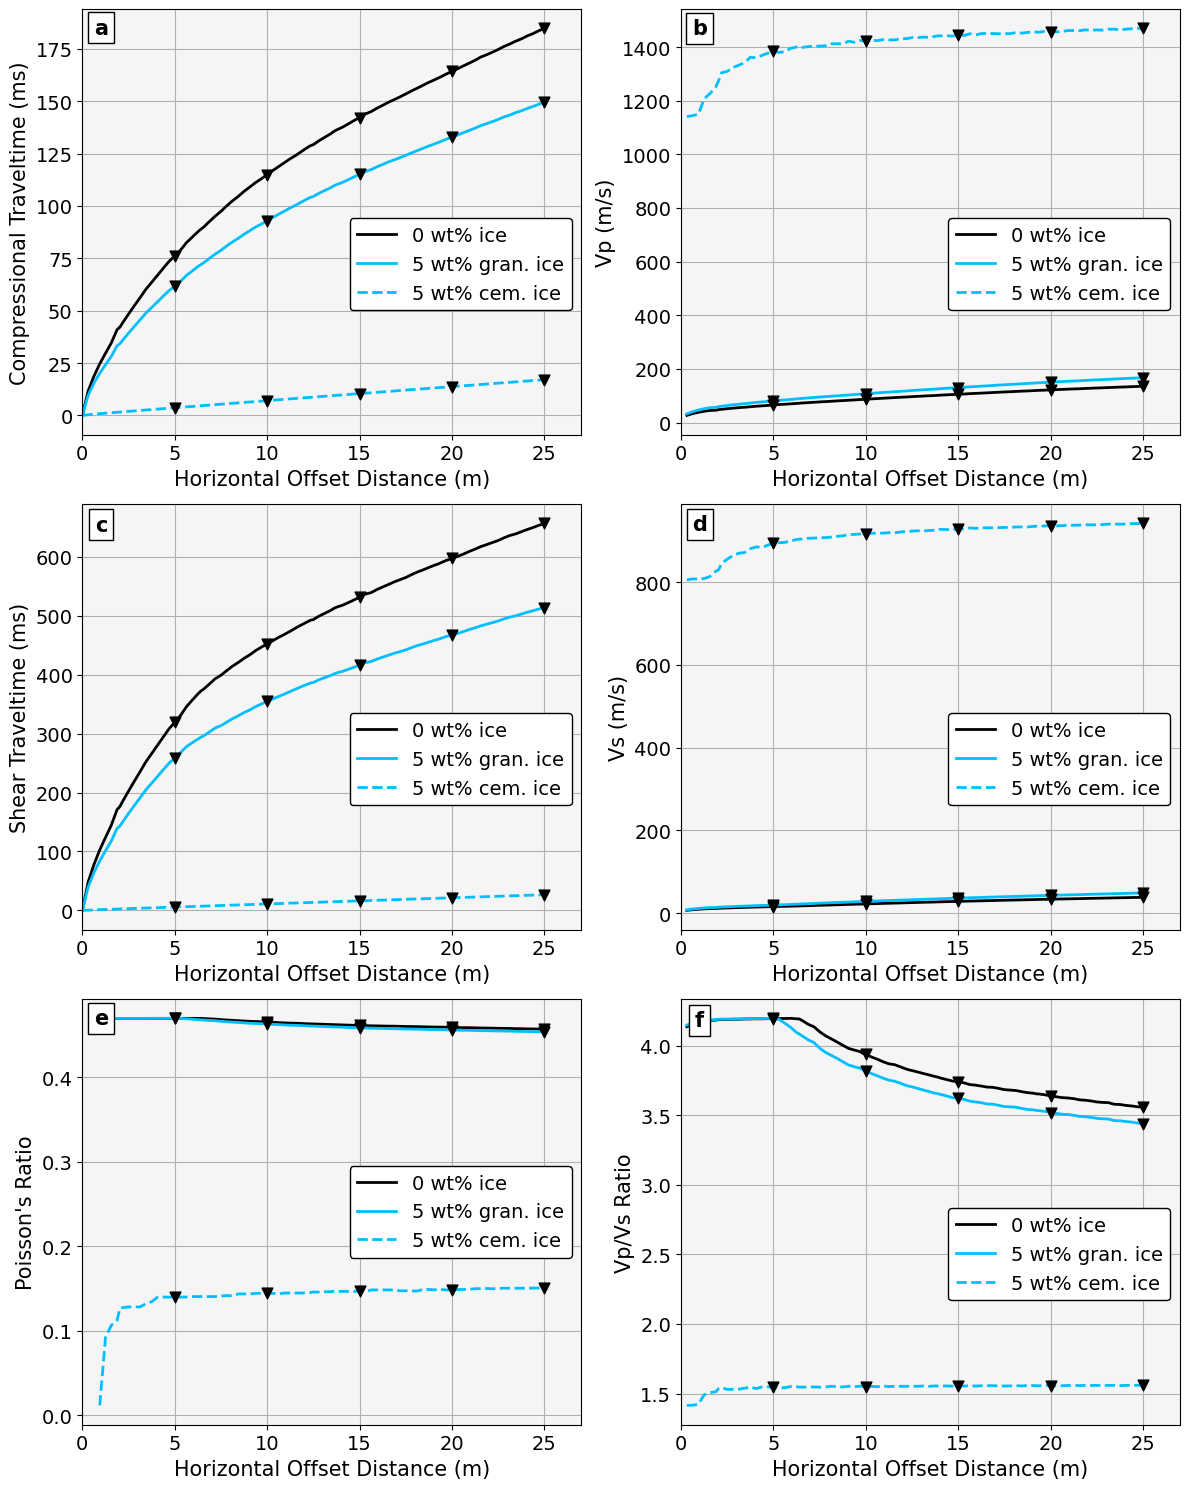

In [29]:
"""
First arrivals plotting for icy cases
"""


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15), sharex=False)

t_all_list = [t_all_0, t_all_5, t_all_10]
comp_offsets_list = [comp_offsets_0, comp_offsets_5, comp_offsets_10]
t_all_list_vs = [t_all_0_vs, t_all_5_vs, t_all_10_vs]
comp_offsets_list_vs = [comp_offsets_0_vs, comp_offsets_5_vs, comp_offsets_10_vs]

colors = ["black", "deepskyblue", "deepskyblue"]
styles = ["-", "-", "--"]
labels = ["0 wt.% ice", "5 wt.% gran. ice", "5 wt.% cem. ice"]
y_labels = ["Compressional Traveltime (ms)", "Vp (m/s)",
           "Shear Traveltime (ms)", "Vs (m/s)",
           "Poisson's Ratio", "Vp/Vs Ratio"]
sublabel = ["a", "b", "c", "d", "e", "f"]
sublabel_ypos = [185, 1470, 655, 940, 0.47, 4.18]

dot_size=60
width=2.
for i, (t_all, t_all_vs, comp_offsets, comp_offsets_vs) in \
enumerate(zip(t_all_list, t_all_list_vs, comp_offsets_list, comp_offsets_list_vs)):
    tmp_vp = comp_offsets/t_all
    tmp_vs = comp_offsets_vs/t_all_vs
    # t_all = medfilt(t_all, kernel_size=7)
    vel_ratio = tmp_vp/tmp_vs
    # poi_ratio = medfilt(rp.elastic.poisson_vel(tmp_vp, tmp_vs), kernel_size=7)
    poi_ratio = rp.filters.median(rp.elastic.poisson_vel(tmp_vp, tmp_vs), size=5)
    # poi_ratio = rp.elastic.poisson_vel(tmp_vp, tmp_vs)
    # time_ratio = rp.filters.median((t_all/t_all_vs), size=7)
    
    ax[0,0].plot(comp_offsets, t_all * 1000, zorder=1, color=colors[i], ls=styles[i],
            label=labels[i], lw=width)
    ax[1,0].plot(comp_offsets_vs, t_all_vs * 1000, zorder=1, color=colors[i], ls=styles[i],
              label=labels[i], lw=width)
    ax[2,0].plot(comp_offsets, poi_ratio, zorder=1, color=colors[i], ls=styles[i],
            label=labels[i], lw=width)

    ax[0,1].plot(comp_offsets, tmp_vp, zorder=1, color=colors[i], ls=styles[i],
            label=labels[i], lw=width)
    ax[1,1].plot(comp_offsets_vs, tmp_vs, zorder=1, color=colors[i], ls=styles[i],
              label=labels[i], lw=width)
    ax[2,1].plot(comp_offsets, vel_ratio, zorder=1, color=colors[i], ls=styles[i],
            label=labels[i], lw=width)

    gidxs = []
    for p in recs:
        curr_gidx = (np.abs(comp_offsets-p)).argmin()
        gidxs.append(curr_gidx)
    
    ax[0,0].scatter(comp_offsets[gidxs], t_all[gidxs] * 1000, marker='v', c='black', s=dot_size, zorder=3)
    ax[1,0].scatter(comp_offsets_vs[gidxs], t_all_vs[gidxs] * 1000, marker='v', c='black', s=dot_size, zorder=3)
    ax[2,0].scatter(comp_offsets[gidxs], poi_ratio[gidxs], marker='v', 
                  c='black', s=dot_size, zorder=3)

    ax[0,1].scatter(comp_offsets[gidxs], tmp_vp[gidxs], marker='v', c='black', s=dot_size, zorder=3)
    ax[1,1].scatter(comp_offsets_vs[gidxs], tmp_vs[gidxs], marker='v', c='black', s=dot_size, zorder=3)
    ax[2,1].scatter(comp_offsets[gidxs], vel_ratio[gidxs], marker='v', 
                  c='black', s=dot_size, zorder=3)


for i, axes in enumerate(ax.flatten()):
    axes.set(axisbelow=True,
             facecolor="whitesmoke",
            xlim=(0,27))
    axes.tick_params(labelsize=14)
    axes.grid("both")
    axes.set_xlabel("Horizontal Offset Distance (m)", fontsize=15)
    if i == 4:
        bbox = (1, 0.5)
    else:
        bbox = (1, 0.4)
    axes.legend(fontsize=14, framealpha=1, edgecolor="black", 
                loc="center right", bbox_to_anchor=bbox)
    axes.set_ylabel(y_labels[i], fontsize=15)
    axes.text(1, sublabel_ypos[i], sublabel[i], ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

plt.tight_layout()
plt.show()
# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/traveltimes.jpg", dpi=1000, bbox_inches = "tight")

## Ice Dependence of Velocity

In [51]:
##~~~~~~~~~~~~~~~~~
## Model Parameters
ice_percs = np.arange(0, 0.11, 0.005)
ice_percs_vol = [round((i/ice_dens) / ((i/ice_dens)+((1-i)/eff_min_density)),4) for i in ice_percs]

second_layer_depth = 10.
second_layer_velocity = 330.
second_layer_vs = 100.

sensors = np.linspace(0, 25, 2)
recs = [25]
max_offset = 25


start = time.time()

t_all_list_vp_gran, t_all_list_vs_gran = [], []
comp_offsets_list_vp_gran, comp_offsets_list_vs_gran = [], []
t_all_list_vp_cem, t_all_list_vs_cem = [], []
comp_offsets_list_vp_cem, comp_offsets_list_vs_cem = [], []
for i, ice_vol_perc in enumerate(ice_percs_vol):
    print(f"Running model {i+1}/{len(ice_percs_vol)} --> {ice_vol_perc} vol% ice")
    
    por_prof, pres_prof = ice_por_pres(ice_vol_perc)
    
    mesh_granp, vel_granp = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vp")
    _, t_all_granp, comp_offsets_granp = raytrace(mesh_granp, vel_granp, recs, max_offset)
    t_all_list_vp_gran.append(t_all_granp)
    comp_offsets_list_vp_gran.append(comp_offsets_granp)

    mesh_grans, vel_grans = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "granular", "vs")
    _, t_all_grans, comp_offsets_grans = raytrace(mesh_grans, vel_grans, recs, max_offset)
    t_all_list_vs_gran.append(t_all_grans)
    comp_offsets_list_vs_gran.append(comp_offsets_grans)

    if ice_vol_perc > 0:
        mesh_cemp, vel_cemp = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "cemented", "vp")
        _, t_all_cemp, comp_offsets_cemp = raytrace(mesh_cemp, vel_cemp, recs, max_offset)
        t_all_list_vp_cem.append(t_all_cemp)
        comp_offsets_list_vp_cem.append(comp_offsets_cemp)
    
        mesh_cems, vel_cems = create_meshes(sensors, ice_vol_perc, por_prof, pres_prof, "cemented", "vs")
        _, t_all_cems, comp_offsets_cems = raytrace(mesh_cems, vel_cems, recs, max_offset)
        t_all_list_vs_cem.append(t_all_cems)
        comp_offsets_list_vs_cem.append(comp_offsets_cems)
    else:  # append the granular data for 0 ice, so only need to compute once
        t_all_list_vp_cem.append(t_all_granp)
        comp_offsets_list_vp_cem.append(comp_offsets_granp)

        t_all_list_vs_cem.append(t_all_grans)
        comp_offsets_list_vs_cem.append(comp_offsets_grans)

end = time.time()
print(f"Model build took {round((end-start)/60, 2)} minutes")


Running model 1/22 --> 0.0 vol% ice


c:\users\amos\onedrive - colorado school of mines\github\rputils\rputils\bounds.py:199: RuntimeWarning: invalid value encountered in double_scalars
  zeta = (um/6) * ((9*km+8*um)/(km+2*um))
c:\users\amos\onedrive - colorado school of mines\github\rputils\rputils\bounds.py:207: RuntimeWarning: invalid value encountered in double_scalars
  k_val = porosity / (k + (4/3)*um)
c:\users\amos\onedrive - colorado school of mines\github\rputils\rputils\bounds.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  hs_k = (sum(k_holder)**-1) - (4/3) * um
c:\users\amos\onedrive - colorado school of mines\github\rputils\rputils\bounds.py:247: RuntimeWarning: divide by zero encountered in double_scalars
  hs_u = (sum(u_holder)**-1) - zeta
C:\Users\amos\miniconda3\envs\cadiss\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
26/12/23 - 16:57:25

Running model 2/22 --> 0.016 vol% ice


26/12/23 - 16:57:51 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:58:07 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:58:23 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:58:38 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 3/22 --> 0.0317 vol% ice


26/12/23 - 16:58:54 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:59:10 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:59:26 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 16:59:42 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 4/22 --> 0.047 vol% ice


26/12/23 - 16:59:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:00:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:00:31 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:00:47 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 5/22 --> 0.062 vol% ice


26/12/23 - 17:01:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:01:20 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:01:36 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:01:52 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 6/22 --> 0.0767 vol% ice


26/12/23 - 17:02:09 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:02:26 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:02:42 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:02:58 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 7/22 --> 0.0911 vol% ice


26/12/23 - 17:03:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:03:32 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:03:48 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:04:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 8/22 --> 0.1051 vol% ice


26/12/23 - 17:04:21 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:04:38 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:04:53 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:05:09 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 9/22 --> 0.1189 vol% ice


26/12/23 - 17:05:26 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:05:42 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:05:59 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:06:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 10/22 --> 0.1324 vol% ice


26/12/23 - 17:06:31 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:06:47 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:07:03 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:07:19 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 11/22 --> 0.1457 vol% ice


26/12/23 - 17:07:35 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:07:51 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:08:06 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:08:22 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 12/22 --> 0.1586 vol% ice


26/12/23 - 17:08:38 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:08:55 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:09:11 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:09:28 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 13/22 --> 0.1713 vol% ice


26/12/23 - 17:09:44 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:10:01 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:10:16 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:10:32 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 14/22 --> 0.1838 vol% ice


26/12/23 - 17:10:48 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:11:05 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:11:21 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:11:37 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 15/22 --> 0.196 vol% ice


26/12/23 - 17:11:53 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:12:09 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:12:25 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:12:41 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 16/22 --> 0.208 vol% ice


26/12/23 - 17:12:57 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:13:13 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:13:29 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:13:45 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 17/22 --> 0.2198 vol% ice


26/12/23 - 17:14:01 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:14:17 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:14:33 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:14:48 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 18/22 --> 0.2313 vol% ice


26/12/23 - 17:15:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:15:20 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:15:36 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:15:52 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 19/22 --> 0.2426 vol% ice


26/12/23 - 17:16:08 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:16:24 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:16:39 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:16:55 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 20/22 --> 0.2537 vol% ice


26/12/23 - 17:17:11 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:17:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:17:43 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:18:00 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 21/22 --> 0.2647 vol% ice


26/12/23 - 17:18:17 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:18:34 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:18:50 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:19:07 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Running model 22/22 --> 0.2754 vol% ice


26/12/23 - 17:19:24 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:19:40 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:19:57 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.
26/12/23 - 17:20:14 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Model build took 22.98 minutes


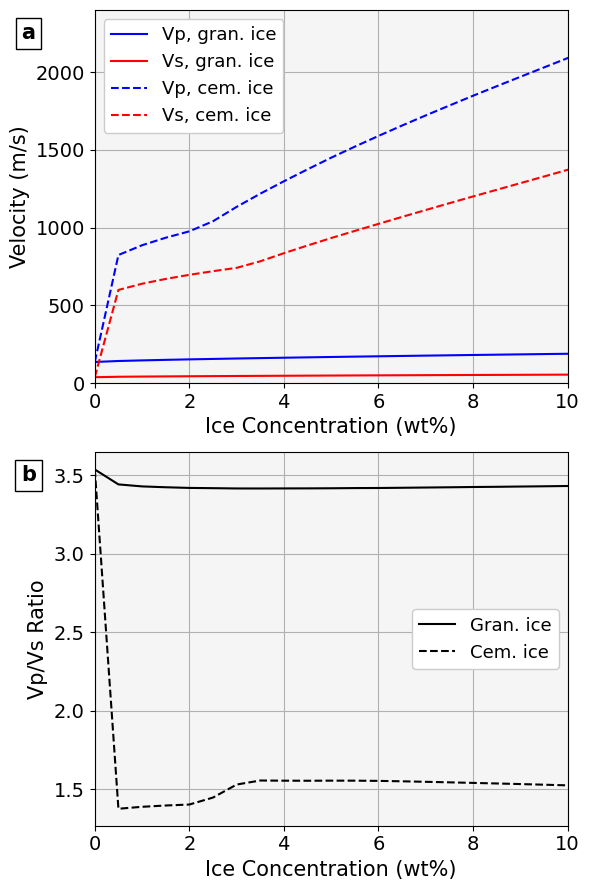

In [56]:
gidxs = []
for p in recs:
    curr_gidx = (np.abs(comp_offsets_list_vp_gran[0]-p)).argmin()
    gidxs.append(curr_gidx)


vp_faroffset_gran, vs_faroffset_gran = [], []
for i, (t_all_vp, t_all_vs, comp_offsets_vp, comp_offsets_vs) in \
enumerate(zip(t_all_list_vp_gran, t_all_list_vs_gran, comp_offsets_list_vp_gran, comp_offsets_list_vs_gran)):
    tmp_vp = comp_offsets_vp[gidxs]/t_all_vp[gidxs]
    tmp_vs = comp_offsets_vs[gidxs]/t_all_vs[gidxs]
    vp_faroffset_gran.append(tmp_vp[-1])
    vs_faroffset_gran.append(tmp_vs[-1])

vp_faroffset_cem, vs_faroffset_cem = [], []
for i, (t_all_vp, t_all_vs, comp_offsets_vp, comp_offsets_vs) in \
enumerate(zip(t_all_list_vp_cem, t_all_list_vs_cem, comp_offsets_list_vp_cem, comp_offsets_list_vs_cem)):
    tmp_vp = comp_offsets_vp[gidxs]/t_all_vp[gidxs]
    tmp_vs = comp_offsets_vs[gidxs]/t_all_vs[gidxs]
    vp_faroffset_cem.append(tmp_vp[-1])
    vs_faroffset_cem.append(tmp_vs[-1])


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,9))

width = 1.5
p1 = ax[0].plot(ice_percs*100, vp_faroffset_gran, color="blue", label="Vp, gran. ice", lw=width)
p2 = ax[0].plot(ice_percs*100, vs_faroffset_gran, color="red", label="Vs, gran. ice", lw=width)
p3 = ax[0].plot(ice_percs*100, vp_faroffset_cem, color="blue", label="Vp, cem. ice", ls="--", lw=width)
p4 = ax[0].plot(ice_percs*100, vs_faroffset_cem, color="red", label="Vs, cem. ice", ls="--", lw=width)

vpvs_gran = np.array(vp_faroffset_gran)/np.array(vs_faroffset_gran)
vpvs_cem = np.array(vp_faroffset_cem)/np.array(vs_faroffset_cem)
p5 = ax[1].plot(ice_percs*100, vpvs_gran, color="black", label="Gran. ice", lw=width)
p6 = ax[1].plot(ice_percs*100, vpvs_cem, color="black", label="Cem. ice", ls="--", lw=width)


for axes in ax:
    axes.set(xlim=(0, 10),
       axisbelow=True,
       facecolor="whitesmoke")
    axes.set_xlabel("Ice Concentration (wt%)", fontsize=15)
    axes.tick_params(axis='both', labelsize=14)
    axes.grid("both")
    axes.legend(framealpha=1, fontsize=13)
ax[0].set_ylim(0, 2400)
ax[0].set_ylabel("Velocity (m/s)", fontsize=15)
ax[1].set_ylabel("Vp/Vs Ratio", fontsize=15)
ax[0].text(-1.4, 2250, "a", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})
ax[1].text(-1.4, 3.5, "b", ha="center", va="center", fontweight="bold", fontsize=15,
          bbox={"facecolor":"white", "alpha":1, "edgecolor":"black"})

plt.tight_layout()
plt.show()

# plt.savefig("../../../Research Work/Papers/pub2/pub2_figs/traveltimes_ice.jpg", dpi=1000, bbox_inches = "tight")